In [2]:
import os
import sys

import pandas as pd
from dotenv import load_dotenv
current_dir = os.getcwd()
sys.path.append(os.path.join(os.path.dirname(current_dir),'src'))
sys.path.append(os.path.dirname(current_dir))


In [14]:
from src.bdd_utils.model_utils import load_training_arguments_from_env
from src.bdd_utils import image_utils, data_utils,metrics_utils
from src.bdd_evaluator.evaluator import Evaluator

In [5]:
# Load environment variables
load_dotenv()
%load_ext autoreload
%autoreload 2

## Validation set prediction

In [7]:
args = load_training_arguments_from_env()
model_path = "/home/jl_fs/bdd100k_detector/models/epoch45.pt"
eval_entity = Evaluator(args,'yolo11s.pt',checkpoint_path=model_path)
val_images_dir = "/home/jl_fs/bdd100k_detector/data/raw/bdd100k/images/100k/val"
output_preds = eval_entity.test(val_images_dir,save_txt=True,save_conf=True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/10000 /home/jl_fs/bdd100k_detector/data/raw/bdd100k/images/100k/val/b1c66a42-6f7d68ca.jpg: 256x416 25 cars, 1 pedestrian, 4 traffic signs, 22.2ms
image 2/10000 /home/jl_fs/bdd100k_detector/data/raw/bdd100k/images/100k/val/b1c81faa-3df17267.jpg: 256x416 1 traffic light, 1 traffic sign, 21.5ms
image 3/10000 /home/jl_fs/bdd100k_detector/data/raw/bdd100k/images/100k/val/b1c81faa-c80764c5.jpg: 256x416 5 cars, 2 traffic signs, 21.5ms
image 4/10000 /h

In [12]:
eval_entity.evaluate()

Ultralytics 8.3.23 🚀 Python-3.10.14 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A5000, 24248MiB)


val: Scanning /home/jl_fs/bdd100k_detector/data/raw/bdd100k/labels/100k/val.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 625/625 [00:50<00:00, 12.32it/s]


                   all      10000     186033      0.662      0.294      0.314       0.18
               bicycle        592       1039      0.415      0.348      0.309       0.15
                   bus       1299       1660      0.618      0.477      0.523      0.405
                   car       9882     102837      0.747      0.638      0.689      0.446
            motorcycle        346        460      0.583      0.298      0.334      0.161
          other person          1          1          1          0          0          0
         other vehicle         70         85      0.158     0.0471     0.0438     0.0296
            pedestrian       3261      13425      0.611      0.424      0.459      0.217
                 rider        527        658      0.511      0.331      0.326      0.154
         traffic light       5651      26884       0.65      0.345       0.39      0.144
          traffic sign       8211      34724      0.674      0.403      0.457      0.237
               traile

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c5d583e46d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.04504

In [8]:
val_df = pd.read_csv('/home/jl_fs/bdd100k_detector/data/processed/bdd100k/val.csv')
unique_labels = sorted(val_df['category'].dropna().unique())  # Drop NaN and sort alphabetically
label2idx = {label: idx for idx, label in enumerate(unique_labels)}
idx2label = {idx: label for label, idx in label2idx.items()}
predictions_path = "/home/jl_fs/bdd100k_detector/runs/bdd100_detector/output_predictions3/labels"
val_unique = val_df[["image_id", "weather", "timeofday", "scene"]].drop_duplicates(subset="image_id")
predictions_df = data_utils.create_predictions_dataframe(predictions_path)
predictions_df["category"] = predictions_df["category_id"].map(idx2label)
predictions_df.to_csv('predictions.csv',index=False)
predictions_df = predictions_df.merge(
    val_unique,  # Select relevant columns from val_df
    on="image_id",  # Merge based on `image_id`
    how="left"      # Use a left join to keep all rows from predictions_df
)

## Get the images where the predictions were poor

In [10]:
# Group predictions_df and val_df by image_id to count the number of annotations
predictions_counts = predictions_df.groupby('image_id').size().reset_index(name='predicted_count')
val_counts = val_df.groupby('image_id').size().reset_index(name='ground_truth_count')

# Merge the two counts DataFrames on image_id
merged_counts = pd.merge(val_counts, predictions_counts, on='image_id', how='left')

# Fill NaN in predicted_count with 0 (for cases where there are no predictions for an image_id)
merged_counts['predicted_count'] = merged_counts['predicted_count'].fillna(0).astype(int)

# Calculate the difference between ground truth and predictions
merged_counts['difference'] = merged_counts['ground_truth_count'] - merged_counts['predicted_count']

# Filter for cases where the predictions are lower than ground truth
underperforming_images = merged_counts[merged_counts['difference'] > 0]

# Sort by the difference in descending order and take the top 20
top_underperforming_images = underperforming_images.sort_values(by='difference', ascending=False).head(20)

In [11]:
top_underperforming_images.head()

,image_id,ground_truth_count,predicted_count,difference
7184,c3a18207-504667c7.jpg,63,11,52
1589,b5a50c2d-ccafe43a.jpg,50,8,42
8630,c71a5c66-93c9eca0.jpg,57,15,42
920,b41d35f8-6cf85033.jpg,59,17,42
4110,bc574681-412ec1a0.jpg,46,9,37


In [16]:
val_df['annotation_id'] = range(1, len(val_df) + 1)

In [17]:

category_metrics,predictions_df = metrics_utils.evaluate_predictions(predictions_df, val_df, iou_threshold=0.5)
category_results = metrics_utils.calculate_category_metrics(category_metrics)
category_results_df = pd.DataFrame.from_dict(category_results, orient='index')


category_results_df.reset_index(inplace=True)
category_results_df.rename(columns={'index': 'Category'}, inplace=True)

In [20]:
predictions_df.head()

,image_id,category_id,norm_cx,norm_cy,norm_w,norm_h,bbox_x1,bbox_y1,bbox_x2,bbox_y2,pred_conf,category,weather,timeofday,scene,TP,annot_id
0,bec7b5c0-43e0242a.jpg,2,0.857876,0.314259,0.278116,0.267156,920.087040,130.090320,1276.075520,322.442640,0.918721,car,undefined,daytime,city street,True,95981.0
1,bec7b5c0-43e0242a.jpg,2,0.526166,0.310774,0.065830,0.110947,631.361472,183.816360,715.623488,263.698200,0.823677,car,undefined,daytime,city street,True,95980.0
2,bec7b5c0-43e0242a.jpg,2,0.487094,0.315987,0.024296,0.061460,607.930752,205.385112,639.029888,249.636168,0.778310,car,undefined,daytime,city street,True,95976.0
3,bec7b5c0-43e0242a.jpg,12,0.689240,0.305796,0.134300,0.173842,796.275200,157.590000,968.179200,282.756240,0.750512,truck,undefined,daytime,city street,True,95979.0
4,bec7b5c0-43e0242a.jpg,1,0.199724,0.300976,0.145324,0.128433,162.639360,170.466840,348.654080,262.938600,0.748510,bus,undefined,daytime,city street,True,95978.0


In [22]:
# Group by 'category' and calculate mean, min, and max
result_df = predictions_df.groupby('category')['pred_conf'].agg(['mean', 'min', 'max']).reset_index()

# Rename columns for better clarity (optional)
result_df.columns = ['category', 'mean_conf', 'min_conf', 'max_conf']

result_df

,category,mean_conf,min_conf,max_conf
0,bicycle,0.423982,0.250179,0.909651
1,bus,0.619618,0.250655,0.949279
2,car,0.581212,0.250000,0.949239
3,motorcycle,0.456430,0.250504,0.853361
4,other vehicle,0.395774,0.264577,0.580318
5,pedestrian,0.444944,0.250009,0.887471
6,rider,0.487212,0.252513,0.878536
7,traffic light,0.447411,0.250030,0.835715
8,traffic sign,0.509058,0.250009,0.936944
9,truck,0.567682,0.250030,0.953601


In [21]:
val_df.head()

,image_id,weather,timeofday,scene,timestamp,category,traffic_light_color,occluded,truncated,bbox_x1,bbox_y1,bbox_x2,bbox_y2,split,image_path,img_width,img_height,annotation_id
0,b1c66a42-6f7d68ca.jpg,overcast,daytime,city street,10000,traffic sign,NaN,False,False,1000.698742,281.992415,1040.626872,326.911560,val,/home/jl_fs/bdd100k_detector/data/raw/bdd100k/...,1280,720,1
1,b1c66a42-6f7d68ca.jpg,overcast,daytime,city street,10000,traffic sign,NaN,False,False,214.613695,172.190058,274.505889,229.586743,val,/home/jl_fs/bdd100k_detector/data/raw/bdd100k/...,1280,720,2
2,b1c66a42-6f7d68ca.jpg,overcast,daytime,city street,10000,traffic sign,NaN,False,False,797.314833,313.186265,829.756437,341.884608,val,/home/jl_fs/bdd100k_detector/data/raw/bdd100k/...,1280,720,3
3,b1c66a42-6f7d68ca.jpg,overcast,daytime,city street,10000,traffic sign,NaN,False,False,652.575363,303.204232,685.016968,315.681772,val,/home/jl_fs/bdd100k_detector/data/raw/bdd100k/...,1280,720,4
4,b1c66a42-6f7d68ca.jpg,overcast,daytime,city street,10000,traffic light,G,False,False,707.476543,311.938510,716.210821,328.159313,val,/home/jl_fs/bdd100k_detector/data/raw/bdd100k/...,1280,720,5


## Sample prediction on data

In [5]:
args = load_training_arguments_from_env()
model_path = "/home/jl_fs/bdd100k_detector/runs/bdd100_detector/train2/weights/best.pt"
eval_entity = Evaluator(args,'yolo11s.pt',checkpoint_path=model_path)
sample_img_path = "/home/jl_fs/bdd100k_detector/data/raw/bdd100k/images/100k/val/b1ceb32e-3f481b43.jpg"
output_preds = eval_entity.test(sample_img_path)


image 1/1 /home/jl_fs/bdd100k_detector/data/raw/bdd100k/images/100k/val/b1ceb32e-3f481b43.jpg: 256x416 11 cars, 1 traffic light, 188.9ms
Speed: 3.3ms preprocess, 188.9ms inference, 118.1ms postprocess per image at shape (1, 3, 256, 416)
Results saved to /home/jl_fs/bdd100k_detector/runs/bdd100_detector/output_predictions3


### Predictions

In [63]:
output_preds[0].boxes.xywh

tensor([[1072.7158,  409.7988,  265.6216,  147.4782],
        [ 846.5389,  393.4537,  113.2317,   68.1273],
        [  25.3268,  370.4816,   50.6537,   65.2421],
        [  87.5841,  372.4232,   81.9931,   52.3141],
        [ 781.4149,  384.8668,   65.8181,   50.1902],
        [ 246.0186,  199.7630,   63.2806,   60.9064],
        [ 919.2630,  413.0110,   76.7202,   73.0877],
        [ 288.1302,  371.1309,  115.7565,   50.2540],
        [ 616.4355,  368.2932,   37.7588,   31.1460],
        [1242.6783,  463.3099,   74.6433,  128.3593],
        [ 235.7655,  362.1938,   63.0650,   45.9209],
        [1235.7290,  470.9583,   75.1298,  106.6324],
        [ 812.0885,  327.2784,   31.6827,   30.5384],
        [ 744.9578,  383.1178,   33.3534,   36.3991],
        [ 303.0775,  368.4806,   90.0090,   49.0701],
        [ 698.1315,  373.7873,   30.0082,   31.4943],
        [1018.7107,  303.7010,   35.4080,   42.0483],
        [ 722.1958,  378.9980,   36.2364,   33.6461],
        [ 587.6407,  360.767

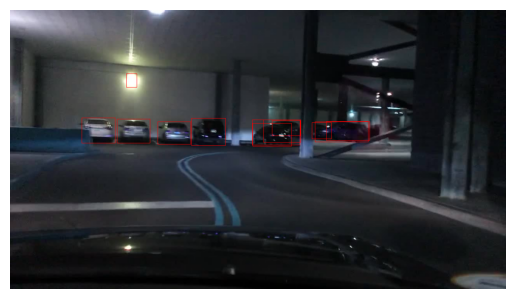

In [6]:
image_utils.display_image_with_boxes(output_preds[0].orig_img,output_preds[0].boxes.xyxy)